In [1]:
#notes i think the old images did not work as it was a grayscale image where each different gray color was a float like 0.26 which is not good for crossentropyloss since it requires integers

# USAGE
# python train.py
# import the necessary packages
from pyimagesearch.dataset2 import SegmentationDataset
from pyimagesearch.model3 import UNet
from pyimagesearch import config
from torch.utils.data import DataLoader

#from torchvision import transforms
from torch.nn import CrossEntropyLoss #we will use crossEntropyLoss here since we have multiple classes
from torch.optim import Adam
import torchvision.transforms as transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
from PIL import Image 

In [2]:
'''
# Define the path to the tar.gz file
tar_file_path = '/home/mje2/projects/REU 2024/Transformers Stuff/CaSSeD.tar.gz'
extracted_folder_path = 'CaSSeD'  # Folder to extract the contents

try:
    # Extract the tar.gz file
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)
    print("Extraction completed successfully.")
except tarfile.ReadError:
    print("Error: The tar.gz file is corrupted or unreadable.")
except EOFError:
    print("Error: Unexpected end of file. The tar.gz file might be incomplete or corrupted.")
    '''

'\n# Define the path to the tar.gz file\ntar_file_path = \'/home/mje2/projects/REU 2024/Transformers Stuff/CaSSeD.tar.gz\'\nextracted_folder_path = \'CaSSeD\'  # Folder to extract the contents\n\ntry:\n    # Extract the tar.gz file\n    with tarfile.open(tar_file_path, \'r:gz\') as tar:\n        tar.extractall(path=extracted_folder_path)\n    print("Extraction completed successfully.")\nexcept tarfile.ReadError:\n    print("Error: The tar.gz file is corrupted or unreadable.")\nexcept EOFError:\n    print("Error: Unexpected end of file. The tar.gz file might be incomplete or corrupted.")\n    '

In [3]:
'''
import os
import tarfile

# Function to check and print the correct path
def check_and_print_path(base_path):
    correct_base_path = os.path.abspath(base_path)
    print("Correct Absolute Path to Dataset:", correct_base_path)

    if os.path.exists(correct_base_path):
        print("Path exists:", correct_base_path)
    else:
        print("Path does not exist:", correct_base_path)

    return correct_base_path

# Function to print the first item in each directory of a .tar.gz file
def print_first_item_in_tarfile_structure(tarfile_path):
    with tarfile.open(tarfile_path, 'r:gz') as tar:
        structure = {}
        for member in tar.getmembers():
            if member.isdir():
                directory = member.name
                if directory not in structure:
                    structure[directory] = None
            else:
                directory = os.path.dirname(member.name)
                if directory not in structure:
                    structure[directory] = member.name

        for directory, first_item in structure.items():
            if first_item:
                print(f'{directory}/ -> {first_item}')
            else:
                print(f'{directory}/')


# Base dataset path
base_path = '../CaSSeD.tar.gz'
absolute_path = check_and_print_path(base_path)

if os.path.exists(absolute_path):
    print_first_item_in_tarfile_structure(absolute_path)
else:
    print("File does not exist, cannot print structure.")
    
    this is what comes out 
Correct Absolute Path to Dataset: /home/mje2/projects/REU 2024/Transformers Stuff/CaSSeD.tar.gz
Path exists: /home/mje2/projects/REU 2024/Transformers Stuff/CaSSeD.tar.gz
'''


'\nimport os\nimport tarfile\n\n# Function to check and print the correct path\ndef check_and_print_path(base_path):\n    correct_base_path = os.path.abspath(base_path)\n    print("Correct Absolute Path to Dataset:", correct_base_path)\n\n    if os.path.exists(correct_base_path):\n        print("Path exists:", correct_base_path)\n    else:\n        print("Path does not exist:", correct_base_path)\n\n    return correct_base_path\n\n# Function to print the first item in each directory of a .tar.gz file\ndef print_first_item_in_tarfile_structure(tarfile_path):\n    with tarfile.open(tarfile_path, \'r:gz\') as tar:\n        structure = {}\n        for member in tar.getmembers():\n            if member.isdir():\n                directory = member.name\n                if directory not in structure:\n                    structure[directory] = None\n            else:\n                directory = os.path.dirname(member.name)\n                if directory not in structure:\n                    

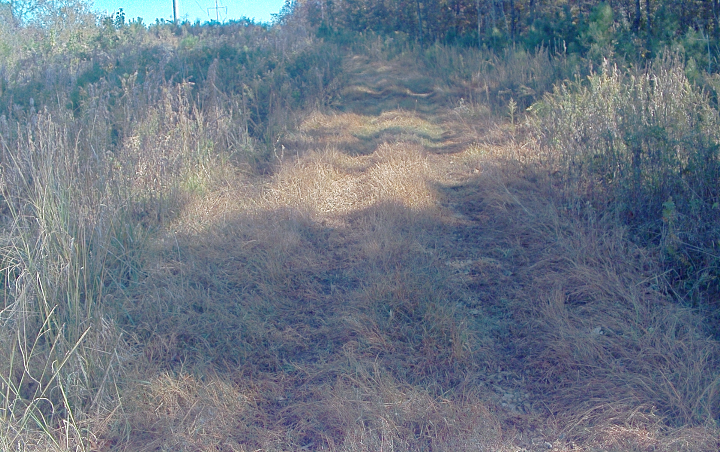

In [4]:
mask = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/masks/mask_101.png")
img = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/imgs/img_101.png")
anno = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/annos/anno_101.jpg")
annoIntMapMask = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/annos/int_maps/mask_101.png")

yeet = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/mixed/Train/annos/int_maps/anno_pln_414.png")
yeet2 = Image.open("/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/mixed/Train/imgs/img_pln_414.png")
yeet2
#We want the img as input and the annoIntMapMask as the target / labels

In [5]:
# import the necessary packages
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import os
from PIL import Image 
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, root, split, transforms=None):
        #loop through each location
        #Go into the split folder
        #Go into images and masks since they will be in pairs
        
        # store the image and mask filepaths, and augmentation
        # transforms
        self.root = root
        
        self.transforms = transforms
        
        #split is included b/c the data has a train, val, and test folder 
        #ex: urRootPath/Brown_Field/Train/annos/int_maps/mask_101.png  (mask in train folder)
        #ex: urRootPath/ (img in val folder)
        
        #stores the image paths and mask paths (duh)
        self.image_paths = []
        self.mask_paths = []
        
        #weird, int_map masks in brown_field is named mask_numberHere.png while in Powerline its anno_pln_numberHere.png
        for trail_name in os.listdir(self.root):
            split_path = os.path.join(root, trail_name, split.capitalize())
            imgs_path = os.path.join(split_path, "imgs")
            masks_path = os.path.join(split_path, "annos/int_maps/")
            for mask_name in os.listdir(masks_path):
                    
                    #Get the int_map mask first
                    mask_path = os.path.join(masks_path, mask_name)
                    self.mask_paths.append(mask_path)
            
                    #Get the corresponding image to that map_mask
                    image_name = "img_" + mask_name.split("_", 1)[1] #need to change file name a little for images
                    image_path = os.path.join(imgs_path, image_name)
                    self.image_paths.append(image_path)
        
        #The images are separated in different folders by trail so we need to loop through those
        #both images and masks have the same trail (b/c image must have a corresponding mask) so we only loop through that once

                    
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.image_paths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image, mask = self.transforms(image, mask)
        # return a tuple of the image and its mask
        return (image, mask)


In [6]:

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
            target = t(target)
        
        #Numpy Array stores image data as [Height, Width, Num_Color_Channels]
        #Pytorch Tensor stores image data as [Num_Color_Channels, Height, Width]

        #We cannot use transforms.ToTensor() for masks as it normalizes the data between 0.0 and 1.0 which we dont want
        #So instead we first convert to numpy array and then to tensor of type int 64 to avoid this
        #Thus our integer labels in the image data is preserved
        
        #mask
        target = np.array(target)
        target = torch.tensor(target, dtype=torch.int64) #int64 b/c target (in this case masks) have to be int64 for crossEntropyLoss

        #however we do want to use ToTensor for images to normalize to help prevent giving too high of an initial value to color values
        #image
        toTensor = transforms.ToTensor()
        image = toTensor(image)
        
        return image, target

#WARNING: Do not use Transform.ToTensor as it normalizes the data [0.0-1.0] which we don't want
#Aug apply to mask and img
transform = []
#WARNING: Interpolation nearrest is needed to prevent the pixels in mask from being blurred when stretched thus messing up the labelIds
transform.append( transforms.Resize((config.INPUT_IMAGE_HEIGHT,config.INPUT_IMAGE_WIDTH), interpolation=Image.NEAREST )) 
transform = Compose(transform)

trainDS = SegmentationDataset('/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT', split='Train',
	transforms=transform)
testDS = SegmentationDataset('/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT', split='Test',
	transforms=transform)


/home/mje2/.conda/envs/mlbd/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [7]:
#Returns image and its mask
#print(len(os.listdir(trainDS.images_dir)))
print(np.unique(trainDS[198][1]))
#only four classes?
#print(trainDS[198][1].unique()) #img shape: torch.Size([3, 128, 128])
#mask shape: torch.Size([1, 128, 128])

[0 1 2 3]


In [8]:
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)


[INFO] found 2536 examples in the training set...
[INFO] found 1088 examples in the test set...


In [9]:
trainDS[198][1].shape

torch.Size([128, 128])

In [10]:
trainDS[198][1].unique()
trainDS[198][1][127][1:100]

tensor([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1])

In [11]:

# initialize our UNet model
unet = UNet(in_channels=3, classes=4).to(config.DEVICE)
# initialize loss function and optimizer
#0 is the index for everything that isn't the traversable terrain
#REMOVED IGNORE_INDEX=0 SINCE DIDNT KNOW HOW TO FIX THIS WITH MIOU FOR NOW
lossFunc = CrossEntropyLoss() #SWAPPED THIS FROM BCEWITHLOGITSLOSS TO CROSSENTROPY SINCE WE USING MULTIPLE CLASSES NOW
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


[INFO] training the network...


100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


[INFO] EPOCH: 1/5
Train loss: 0.917714


100%|██████████| 40/40 [00:57<00:00,  1.44s/it]


[INFO] EPOCH: 2/5
Train loss: 0.676524


100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


[INFO] EPOCH: 3/5
Train loss: 0.577510


100%|██████████| 40/40 [00:55<00:00,  1.38s/it]


[INFO] EPOCH: 4/5
Train loss: 0.545070


100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


[INFO] EPOCH: 5/5
Train loss: 0.494773
[INFO] total time taken to train the model: 289.11s


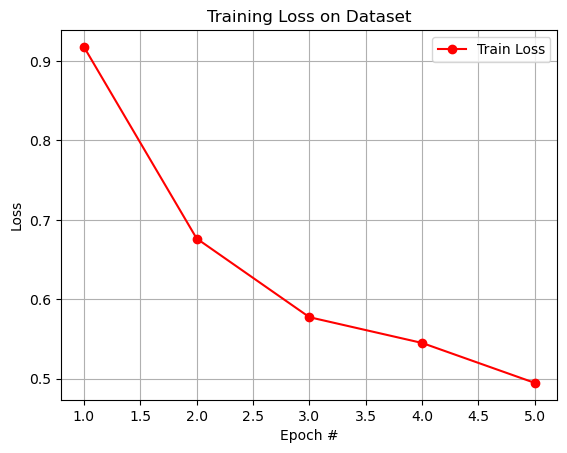

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Initialize lists to store training and test losses
train_losses = []
test_losses = []

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(config.NUM_EPOCHS):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    trainLoader = tqdm(trainLoader)
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()  # Make sure to use loss.item() to get the scalar value
    # calculate the average training loss
    avgTrainLoss = totalTrainLoss / trainSteps
    train_losses.append(avgTrainLoss)
    
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}".format(avgTrainLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

# Plotting the training losses
plt.figure()
plt.plot(range(1, config.NUM_EPOCHS + 1), train_losses, label='Train Loss', color='red', marker='o')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

[INFO] loading up test image paths...
[INFO] load up model...


  0%|          | 0/1088 [00:00<?, ?it/s]

Input shape y is torch.Size([1, 128, 128])
y unique tensor([0, 1, 2, 3], device='cuda:0')
origMask has these unique integers [0 1 2 3]
Input shape X is torch.Size([1, 3, 128, 128])


  0%|          | 0/1088 [00:00<?, ?it/s]

unique int for pred mask is tensor([-8.8185, -8.7662, -8.7638,  ...,  9.9185,  9.9240,  9.9295],
       device='cuda:0')
Output shape is torch.Size([1, 4, 128, 128])
Pred_labels shape is torch.Size([1, 128, 128])
Number of unique label ids is 4


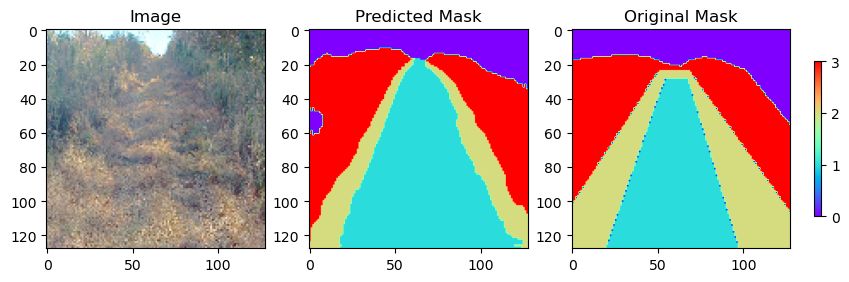

In [13]:
#MANY IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask, numClasses=4):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	norm = mcolors.Normalize(vmin=0, vmax=numClasses-1) #needed so original and predicted mask have same color for each integer index
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask, cmap="rainbow", norm=norm)
	origMaskImg = ax[2].imshow(origMask, cmap="rainbow", norm=norm)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	# Add colorbar
	cbar = figure.colorbar(origMaskImg, ax=ax, orientation='vertical', fraction=0.01, pad=0.03)
	cbar.set_ticks(range(numClasses))
	cbar.set_ticklabels([str(i) for i in range(numClasses)])
	#figure.tight_layout()
	figure.show()
def make_predictions(model, dataLoader):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
		for idx, batch in enumerate(tqdm(dataLoader)):
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				X, y = batch # here 's' is the name of the file stored in the root directory
				X, y = X.to(config.DEVICE), y.to(config.DEVICE)
				print("Input shape y is {}".format(y.shape))
				print("y unique {}".format(y.unique()))
				toPilImage = transforms.ToPILImage()
				image = toPilImage(X.squeeze().to('cpu'))
				origMask = y.squeeze().to('cpu')
				print("origMask has these unique integers {}".format(np.unique( np.array(origMask) ) ) )
				print("Input shape X is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				print("unique int for pred mask is {}".format(predictions.unique()))
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				#pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				#print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				break #so it only iterates once          
	prepare_plot(image, pred_labels.squeeze(), origMask)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
trainLoaderEval = DataLoader(testDS, shuffle=True,
	batch_size=1, pin_memory=config.PIN_MEMORY,
	)
make_predictions(unet, trainLoaderEval)


In [14]:
#test = iter(trainLoaderEval)
#ree = next(test)

In [15]:
#ree

[INFO] loading up test image paths...
[INFO] load up model...
Input shape is torch.Size([1, 3, 256, 256])
Output shape is torch.Size([1, 4, 256, 256])
Pred_labels shape is torch.Size([1, 256, 256])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

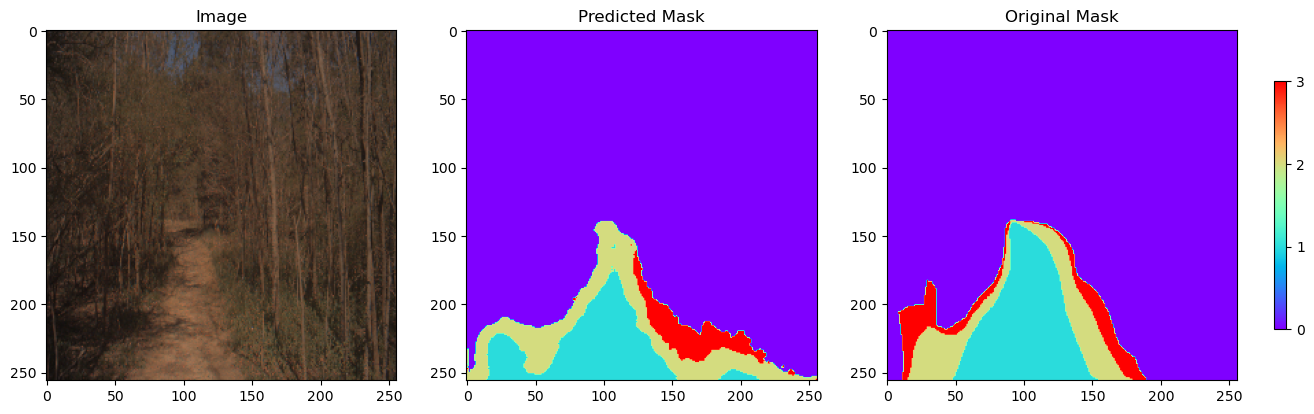

In [16]:
#SINGLE IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask, numClasses=4):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
	# plot the original image, its mask, and the predicted mask
	norm = mcolors.Normalize(vmin=0, vmax=numClasses-1) #needed so original and predicted mask have same color for each integer index
	
	ax[0].imshow(origImage)
	predMaskImg = ax[1].imshow(predMask, cmap="rainbow", norm=norm) 
	origMaskImg = ax[2].imshow(origMask, cmap="rainbow", norm=norm) #store as variable also to be used for colorbar
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	# Add colorbar
	cbar = figure.colorbar(origMaskImg, ax=ax, orientation='vertical', fraction=0.01, pad=0.03)
	cbar.set_ticks(range(numClasses))
	cbar.set_ticklabels([str(i) for i in range(numClasses)])
	#figure.tight_layout()
	figure.show()
def make_predictions(model, imagePath, maskPath):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				image = Image.open(imagePath)
				maskImg = Image.open(maskPath)
				# resize the image and make a copy of it for visualization
				image = image.resize((256,256), resample=Image.NEAREST)
				maskImg = maskImg.resize((256,256), resample=Image.NEAREST)
				PILtoTensor = transforms.ToTensor()
				X = PILtoTensor(image)
				X = X.to(config.DEVICE) #converts to tensor and moves to gpu if there is gpu
				X = X.unsqueeze(0) #this is the model normally expacts input in the form of torch.Size([batch_size, num_channels, height, width])
				#but X right now is in the form of [3, 128, 128] so we do unsqueeze to convert it to [1, 3, 128, 128] for predicting on our one image
				print("Input shape is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				#pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				#pred_labels = pred_labels.squeeze()                
	# Functions to save predictions as images 
	def save_as_images(tensor_pred, image_name):
		tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
		#filename = f"{folder}\{image_name}.png"
		filename = f"{image_name}.png"
		tensor_pred.save(filename)
	save_as_images(pred_labels, "yeet")
	prepare_plot(image, pred_labels.squeeze(), maskImg)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
#imgPath = "dataset/data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
#maskPath = "dataset/data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"
imgPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/imgs/img_101.png"
maskPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Train/annos/int_maps/mask_101.png"

imgPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Test/imgs/img_118.png"
maskPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Brown_Field/Test/annos/int_maps/mask_118.png"

imgPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Main_Trail/Test/imgs/img_251.png"
maskPath = "/home/mje2/projects/REU 2024/Transformers Stuff/CaT/CAT/Main_Trail/Test/annos/int_maps/mask_251.png"

make_predictions(unet, imgPath, maskPath)


In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
from tqdm import tqdm

# Function to calculate mIoU
def calc_miou(model, val_loader, num_classes=4):
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(val_loader)):
            inputs, labels = batch 
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            predicted = predicted.to('cpu')
            labels = labels.to('cpu')

            predictions.append(predicted.numpy())
            targets.append(labels.numpy())

    if not predictions or not targets:
        print("[ERROR] No predictions or targets were collected.")
        return None, None, None

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0).astype(np.int64)

    targets = targets.flatten()
    predictions = predictions.flatten()

    if targets.size == 0 or predictions.size == 0:
        print("[ERROR] Flattened targets or predictions are empty.")
        return None, None, None

    confusion_mat = confusion_matrix(targets, predictions)
    iou_per_class = np.diag(confusion_mat) / (confusion_mat.sum(axis=1) + confusion_mat.sum(axis=0) - np.diag(confusion_mat))
    mean_iou = np.nanmean(iou_per_class)

    print(f"[DEBUG] Mean IoU: {mean_iou}")
    print(f"[DEBUG] IoU per class: {iou_per_class}")
    print(f"[DEBUG] Confusion Matrix: {confusion_mat}")

    return mean_iou, iou_per_class, confusion_mat


In [18]:
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
testLoaderEval = DataLoader(testDS, shuffle=False,
	batch_size=1, pin_memory=config.PIN_MEMORY)
calc_miou(unet, testLoaderEval)

100%|██████████| 1088/1088 [00:23<00:00, 46.27it/s]


[DEBUG] Mean IoU: 0.6133933572209518
[DEBUG] IoU per class: [0.80933782 0.7501291  0.31154449 0.58256202]
[DEBUG] Confusion Matrix: [[5249650   47434  115786  600870]
 [  14676 4735544  154474   36294]
 [  32974 1217706 1128216  312486]
 [ 424962  106844  659722 2988154]]


(0.6133933572209518,
 array([0.80933782, 0.7501291 , 0.31154449, 0.58256202]),
 array([[5249650,   47434,  115786,  600870],
        [  14676, 4735544,  154474,   36294],
        [  32974, 1217706, 1128216,  312486],
        [ 424962,  106844,  659722, 2988154]]))

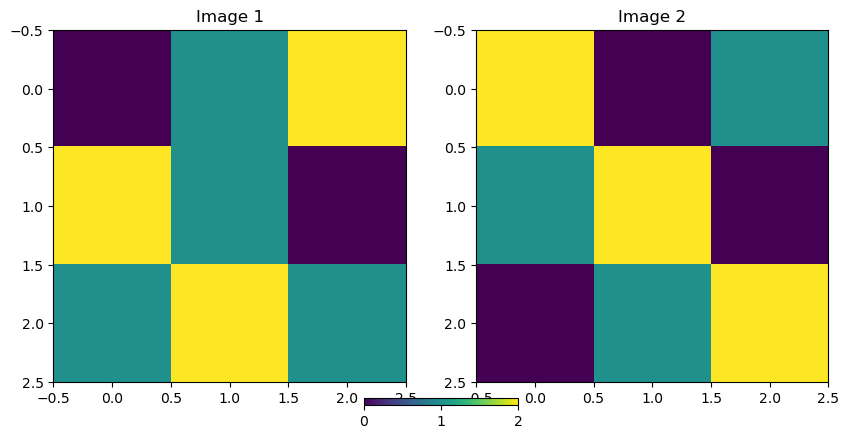

In [19]:
import numpy as np
import matplotlib.colors as mcolors

# Create sample data
image1 = np.array([[0, 1, 2], [2, 1, 0], [1, 2, 1]])
image2 = np.array([[2, 0, 1], [1, 2, 0], [0, 1, 2]])

# Define the colormap and normalization
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=2)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im1 = axes[0].imshow(image1, cmap=cmap, norm=norm)
axes[0].set_title('Image 1')

im2 = axes[1].imshow(image2, cmap=cmap, norm=norm)
axes[1].set_title('Image 2')

# Add colorbar
fig.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)

plt.show()

In [20]:
image1

array([[0, 1, 2],
       [2, 1, 0],
       [1, 2, 1]])

In [21]:
image2

array([[2, 0, 1],
       [1, 2, 0],
       [0, 1, 2]])

In [22]:
#1 is blue
# 2 is green
# 3 is red
# 0 is black

In [23]:
wavy = [0, 2, 3, 4]
wavy[1:3]

[2, 3]

[INFO] training the network...


100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


[DEBUG] Training epoch 1/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


[DEBUG] Mean IoU: 0.38246450998128695
[DEBUG] IoU per class: [0.60166793 0.62563807 0.09091244 0.2116396 ]
[DEBUG] Confusion Matrix: [[5617232   67182   34900  294426]
 [ 255120 3846558  236044  603266]
 [ 501880  938648  281420  969434]
 [2565360  201398  133180 1279744]]
[INFO] EPOCH: 1/12
Train loss: 0.925507
Mean IoU: 0.38246450998128695


100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


[DEBUG] Training epoch 2/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.20s/it]


[DEBUG] Mean IoU: 0.5472674301812654
[DEBUG] IoU per class: [0.72551682 0.73303889 0.31287435 0.41763965]
[DEBUG] Confusion Matrix: [[5605594   30356   91184  286606]
 [  92574 4110520  511012  226882]
 [ 123880  578636 1126098  862768]
 [1496152   57526  305624 2320380]]
[INFO] EPOCH: 2/12
Train loss: 0.621207
Mean IoU: 0.5472674301812654


100%|██████████| 40/40 [01:00<00:00,  1.51s/it]


[DEBUG] Training epoch 3/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.22s/it]


[DEBUG] Mean IoU: 0.5168895670010752
[DEBUG] IoU per class: [0.71953765 0.67828502 0.26716331 0.40257228]
[DEBUG] Confusion Matrix: [[5773478   16030   31008  193224]
 [ 155402 3558328  963746  263512]
 [ 231852  260486 1036568 1162476]
 [1622878   28562  193768 2334474]]
[INFO] EPOCH: 3/12
Train loss: 0.536821
Mean IoU: 0.5168895670010752


100%|██████████| 40/40 [00:59<00:00,  1.49s/it]


[DEBUG] Training epoch 4/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


[DEBUG] Mean IoU: 0.5542842253109861
[DEBUG] IoU per class: [0.74550292 0.71308797 0.30102784 0.45751817]
[DEBUG] Confusion Matrix: [[5517728   43834   54570  397608]
 [ 154174 4444780  321308   20726]
 [ 236936 1034768 1146364  273314]
 [ 996500  213554  740906 2228722]]
[INFO] EPOCH: 4/12
Train loss: 0.497741
Mean IoU: 0.5542842253109861


100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


[DEBUG] Training epoch 5/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


[DEBUG] Mean IoU: 0.6350134349160226
[DEBUG] IoU per class: [0.78801782 0.78111378 0.43402183 0.53690031]
[DEBUG] Confusion Matrix: [[5640972   37074   87024  248670]
 [  64718 4378852  456894   40524]
 [ 129502  555746 1650118  356016]
 [ 950472   72100  566624 2590486]]
[INFO] EPOCH: 5/12
Train loss: 0.489449
Mean IoU: 0.6350134349160226


100%|██████████| 40/40 [00:58<00:00,  1.47s/it]


[DEBUG] Training epoch 6/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:21<00:00,  1.27s/it]


[DEBUG] Mean IoU: 0.6362525383083312
[DEBUG] IoU per class: [0.8035266  0.78380513 0.39595013 0.5617283 ]
[DEBUG] Confusion Matrix: [[5679318   38416   47870  248136]
 [  40982 4601386  275632   22988]
 [ 135442  806808 1400162  348970]
 [ 877826   84362  521324 2696170]]
[INFO] EPOCH: 6/12
Train loss: 0.445259
Mean IoU: 0.6362525383083312


100%|██████████| 40/40 [01:00<00:00,  1.50s/it]


[DEBUG] Training epoch 7/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:21<00:00,  1.24s/it]


[DEBUG] Mean IoU: 0.6906676073171021
[DEBUG] IoU per class: [0.83781407 0.81737212 0.48440835 0.6230759 ]
[DEBUG] Confusion Matrix: [[5607446   28642   64396  313256]
 [  22146 4464802  424770   29270]
 [  64020  458152 1778482  390728]
 [ 593042   34604  490904 3061132]]
[INFO] EPOCH: 7/12
Train loss: 0.429390
Mean IoU: 0.6906676073171021


100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


[DEBUG] Training epoch 8/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:21<00:00,  1.25s/it]


[DEBUG] Mean IoU: 0.6436365730447343
[DEBUG] IoU per class: [0.79620661 0.79874119 0.42379638 0.55580211]
[DEBUG] Confusion Matrix: [[5749478   17994   42904  203364]
 [  64044 4288360  481156  107428]
 [ 125626  389852 1470320  705584]
 [1017678   20064  253960 2887980]]
[INFO] EPOCH: 8/12
Train loss: 0.392331
Mean IoU: 0.6436365730447343


100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


[DEBUG] Training epoch 9/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


[DEBUG] Mean IoU: 0.7013242844978467
[DEBUG] IoU per class: [0.85032184 0.81944186 0.46677374 0.66875969]
[DEBUG] Confusion Matrix: [[5535318   41248   60500  376674]
 [  29184 4639788  251026   20990]
 [  75302  619300 1583894  412886]
 [ 391448   60596  390372 3337266]]
[INFO] EPOCH: 9/12
Train loss: 0.377448
Mean IoU: 0.7013242844978467


100%|██████████| 40/40 [01:01<00:00,  1.53s/it]


[DEBUG] Training epoch 10/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.23s/it]


[DEBUG] Mean IoU: 0.6597092757662721
[DEBUG] IoU per class: [0.80697242 0.79841776 0.47335006 0.56009686]
[DEBUG] Confusion Matrix: [[5766010   37654   83356  126720]
 [  25244 4367532  535710   12502]
 [  81498  418886 1769072  421926]
 [1024756   72706  426896 2655324]]
[INFO] EPOCH: 10/12
Train loss: 0.359536
Mean IoU: 0.6597092757662721


100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


[DEBUG] Training epoch 11/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


[DEBUG] Mean IoU: 0.7079372800902035
[DEBUG] IoU per class: [0.8591239  0.8210609  0.49338587 0.65817845]
[DEBUG] Confusion Matrix: [[5713808   40060   48922  210950]
 [  19020 4660340  250586   11042]
 [  87696  627530 1735396  240760]
 [ 530282   67420  526430 3055550]]
[INFO] EPOCH: 11/12
Train loss: 0.347218
Mean IoU: 0.7079372800902035


100%|██████████| 40/40 [01:01<00:00,  1.55s/it]


[DEBUG] Training epoch 12/12 completed. Calculating mIoU...


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


[DEBUG] Mean IoU: 0.6858996127125536
[DEBUG] IoU per class: [0.81788219 0.83052969 0.5030754  0.59211116]
[DEBUG] Confusion Matrix: [[5840060   33770   50262   89648]
 [  29446 4635148  262470   13924]
 [ 105300  562690 1729698  293694]
 [ 991980   43506  434134 2710062]]
[INFO] EPOCH: 12/12
Train loss: 0.331376
Mean IoU: 0.6858996127125536
[INFO] total time taken to train the model: 1015.73s


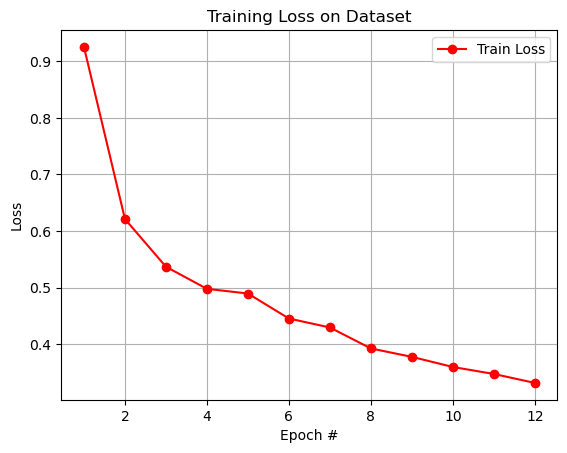

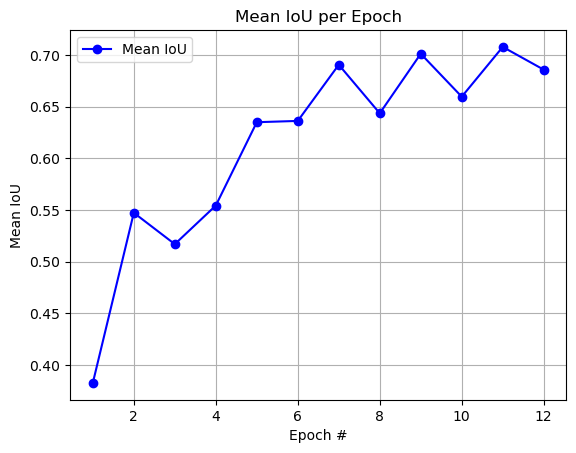

In [24]:
def train_model_and_calc_miou(unet, trainLoader, testLoader, num_epochs, config):
    train_losses = []
    miou_per_epoch = []

    # initialize the optimizer and loss function
    lossFunc = CrossEntropyLoss()
    opt = Adam(unet.parameters(), lr=config.INIT_LR)
    trainSteps = len(trainLoader)
    testSteps = len(testLoader)

    print("[INFO] training the network...")
    startTime = time.time()
    for e in range(num_epochs):
        # set the model in training mode
        unet.train()
        totalTrainLoss = 0
        trainLoaderIter = tqdm(trainLoader)

        for (i, (x, y)) in enumerate(trainLoaderIter):
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            pred = unet(x)
            loss = lossFunc(pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            totalTrainLoss += loss.item()
        
        avgTrainLoss = totalTrainLoss / trainSteps
        train_losses.append(avgTrainLoss)

        print(f"[DEBUG] Training epoch {e+1}/{num_epochs} completed. Calculating mIoU...")
        
        # Initialize mean_iou to handle cases where calc_miou might fail
        mean_iou = 0
        try:
            mean_iou, iou_per_class, confusion_mat = calc_miou(unet, testLoader)
            if mean_iou is not None:
                miou_per_epoch.append(mean_iou)
            else:
                print("[ERROR] mIoU calculation returned None for epoch:", e + 1)
                miou_per_epoch.append(0)
        except Exception as ex:
            print(f"[ERROR] mIoU calculation failed for epoch {e+1}: {ex}")
            miou_per_epoch.append(0)

        print(f"[INFO] EPOCH: {e+1}/{num_epochs}")
        print(f"Train loss: {avgTrainLoss:.6f}")
        print(f"Mean IoU: {mean_iou}")

    endTime = time.time()
    print(f"[INFO] total time taken to train the model: {endTime - startTime:.2f}s")

    # Plotting the training losses
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='red', marker='o')
    plt.title('Training Loss on Dataset')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the mIoU per epoch
    plt.figure()
    plt.plot(range(1, num_epochs + 1), miou_per_epoch, label='Mean IoU', color='blue', marker='o')
    plt.title('Mean IoU per Epoch')
    plt.xlabel('Epoch #')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create the data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False, batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)

# Initialize the model
unet = UNet(in_channels=3, classes=4).to(config.DEVICE)

# Train the model and calculate mIoU for each epoch
train_model_and_calc_miou(unet, trainLoader, testLoader, num_epochs=12, config=config)


100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


[DEBUG] Mean IoU: 0.6858996127125536
[DEBUG] IoU per class: [0.81788219 0.83052969 0.5030754  0.59211116]
[DEBUG] Confusion Matrix: [[5840060   33770   50262   89648]
 [  29446 4635148  262470   13924]
 [ 105300  562690 1729698  293694]
 [ 991980   43506  434134 2710062]]


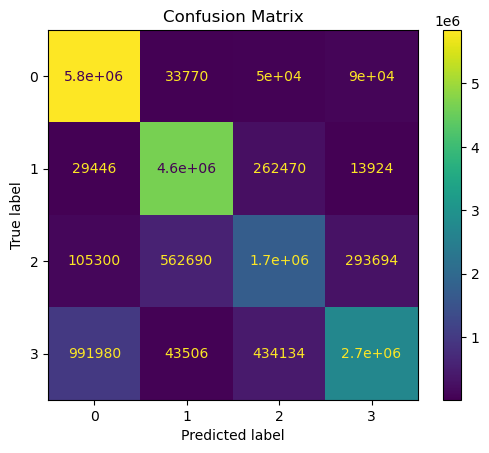

In [25]:
# Function to display confusion matrix
def display_confusion_matrix(confusion_mat):
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[str(i) for i in range(4)])
    disp.plot(cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate and display confusion matrix after training
mean_iou, iou_per_class, confusion_mat = calc_miou(unet, testLoader)
display_confusion_matrix(confusion_mat)
